# **S & P Stock closing price prediction system**

### Importing required libraries and packages:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras import backend as K
import math

from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [2]:
# Mounting the google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Link to the desired repository in google drive:
%cd /content/drive/MyDrive/AI_engr_task/Stock_price_pred

/content/drive/MyDrive/AI_engr_task/Stock_price_pred


## Data Preprocessing

In [4]:
# Reading the dataset file:
df = pd.read_csv("all_stocks_5yr.csv")
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
# Renaming columns 'close' and 'Name' as:
df = df.rename(columns={'close': 'closing_price', 'Name': 'company_name'})

# Dataset summary and desription:
df.describe()

,open,high,low,closing_price,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           619040 non-null  object 
 1   open           619029 non-null  float64
 2   high           619032 non-null  float64
 3   low            619032 non-null  float64
 4   closing_price  619040 non-null  float64
 5   volume         619040 non-null  int64  
 6   company_name   619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [7]:
# filling th emissing values with forward fill values as:

df['open'].fillna(method='ffill', inplace=True)
df['high'].fillna(method='ffill', inplace=True)
df['low'].fillna(method='ffill', inplace=True)

In [8]:
# Converting the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# set the date column as the index
df = df.set_index('date')

# sort the dataframe by the index
df = df.sort_index()
df.head()

,open,high,low,closing_price,volume,company_name
date,,,,,,
2013-02-08,15.07,15.1200,14.630,14.75,8407500,AAL
2013-02-08,81.22,81.9300,80.940,81.89,296853,SLG
2013-02-08,78.24,79.0700,78.125,79.07,4632684,SLB
2013-02-08,236.64,238.6924,235.750,238.16,552207,BLK
2013-02-08,89.04,89.4800,88.910,89.16,554948,SJM


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 619040 entries, 2013-02-08 to 2018-02-07
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   open           619040 non-null  float64
 1   high           619040 non-null  float64
 2   low            619040 non-null  float64
 3   closing_price  619040 non-null  float64
 4   volume         619040 non-null  int64  
 5   company_name   619040 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 33.1+ MB


## Exploratory Data Analysis


*   To observe and visualize the closing prices of some of the famous companies
*   To observe and visualize the Volumes (Number of shares tradded per day) of some of the famous companies


In [47]:
# Example list of selected company names:
selected_companies = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
sel_comp_names = ['Apple', 'Google', 'Microsoft', 'Amazon']
filtered_df = df[df['company_name'].isin(selected_companies)]

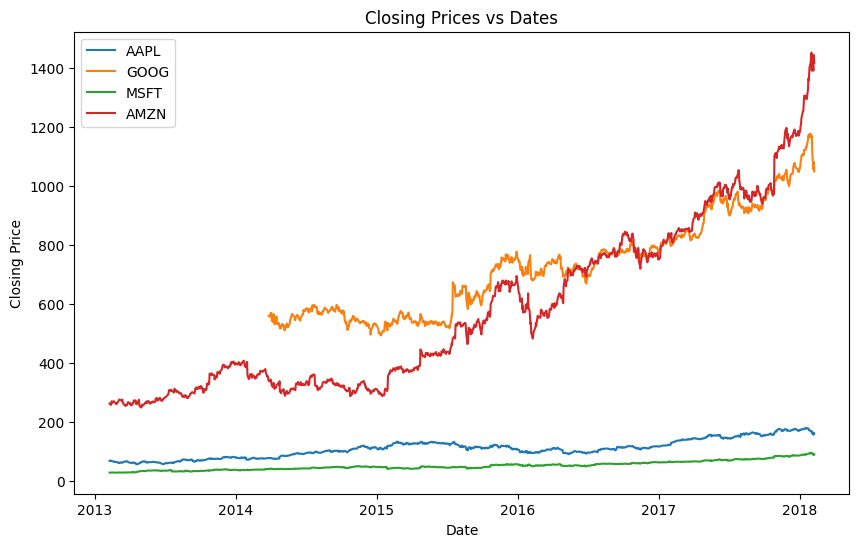

In [48]:
# Plotting the closing_prices of 4 famous companies as:
fig, ax = plt.subplots(figsize=(10, 6))

for company in selected_companies:
    data = filtered_df[filtered_df['company_name'] == company]
    ax.plot(data.index, data['closing_price'], label=company)

ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.set_title('Closing Prices vs Dates')
ax.legend()

plt.show()

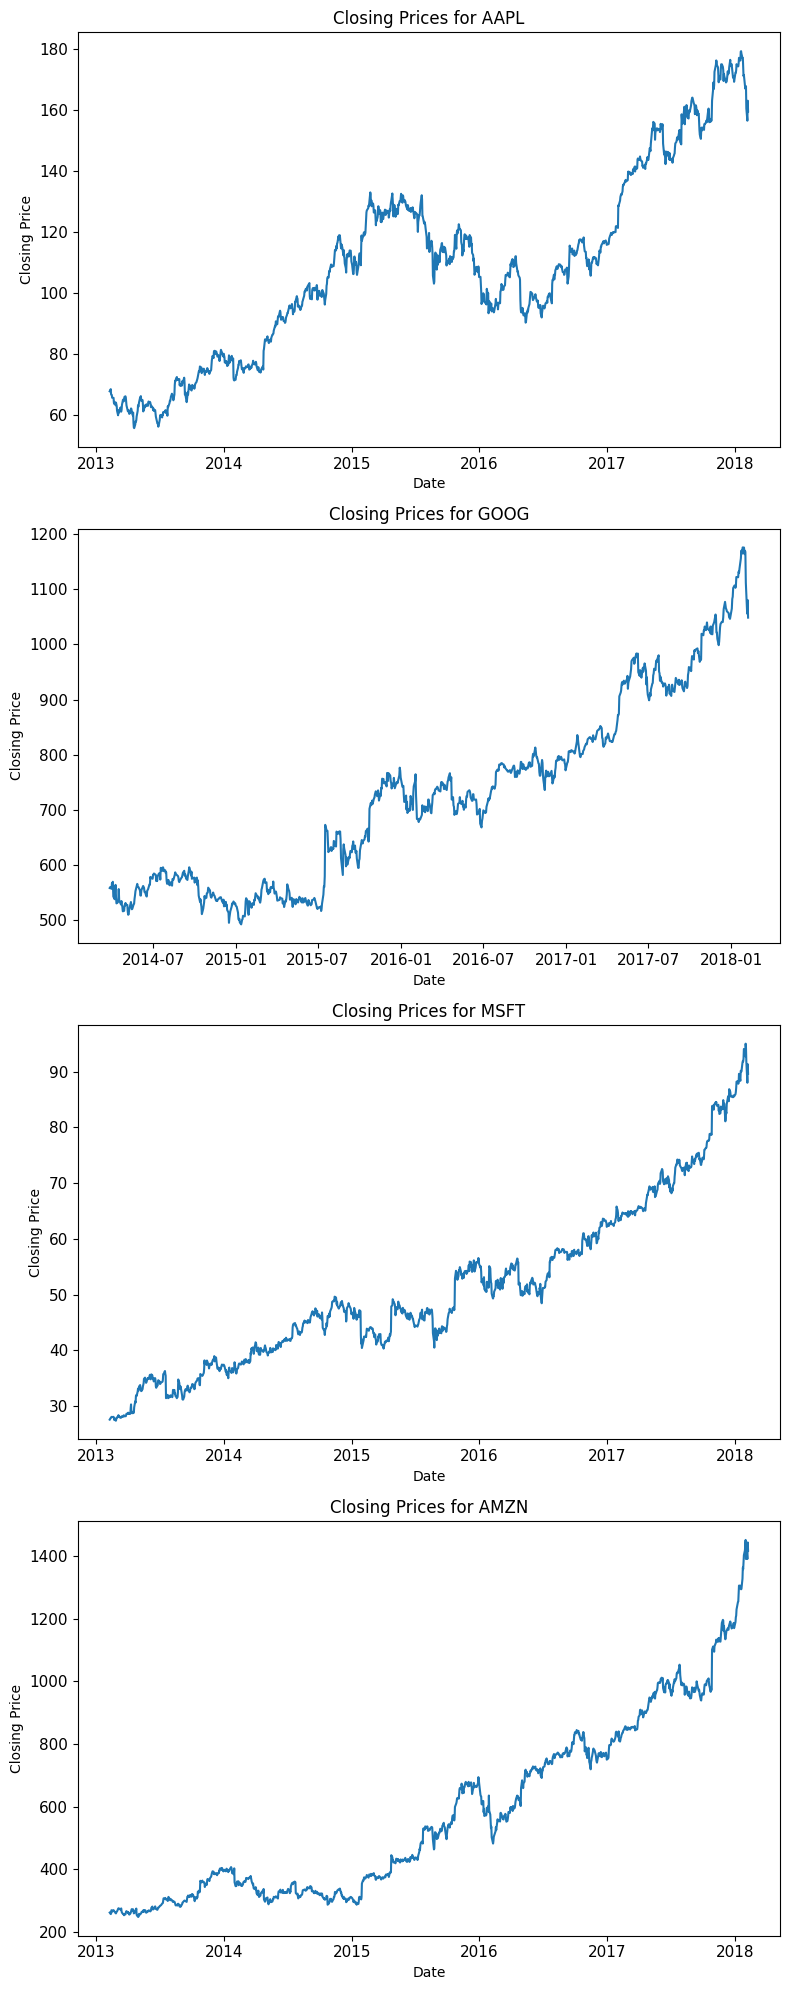

In [49]:
# To Create subplots for each company
fig, axes = plt.subplots(len(selected_companies), 1, figsize=(8, 5 * len(selected_companies)))

# Plot the closing prices vs dates for each company
for i, company in enumerate(selected_companies):
    data = filtered_df[filtered_df['company_name'] == company]
    ax = axes[i] if len(selected_companies) > 1 else axes
    ax.plot(data.index, data['closing_price'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.set_title(f'Closing Prices for {company}')
    # Decrease the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize= 11)
    ax.tick_params(axis='y', labelsize= 11)


plt.tight_layout()
plt.show()

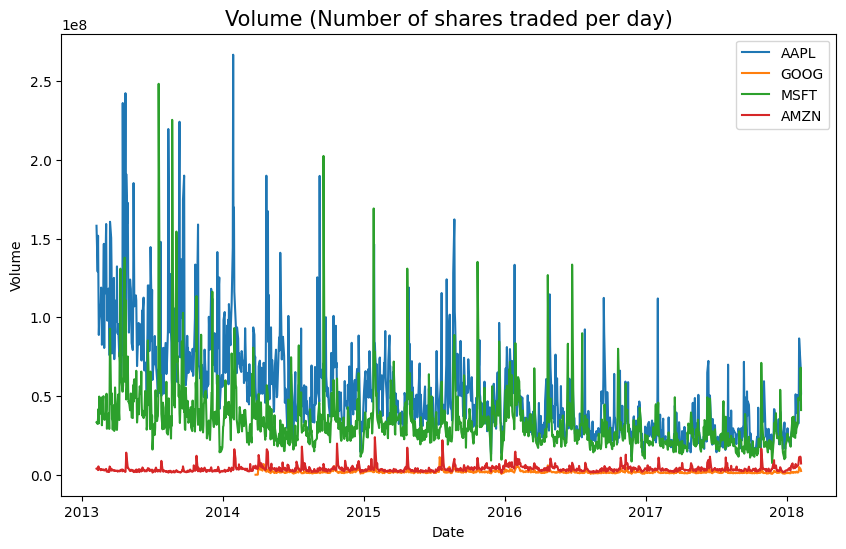

In [50]:
# Plotting the Volumes of 4 famous companies as:
fig, ax = plt.subplots(figsize=(10, 6))

for company in selected_companies:
    data = filtered_df[filtered_df['company_name'] == company]
    ax.plot(data.index, data['volume'], label=company)

ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.set_title('Volume (Number of shares traded per day)', fontsize = 15)
ax.legend()

plt.show()

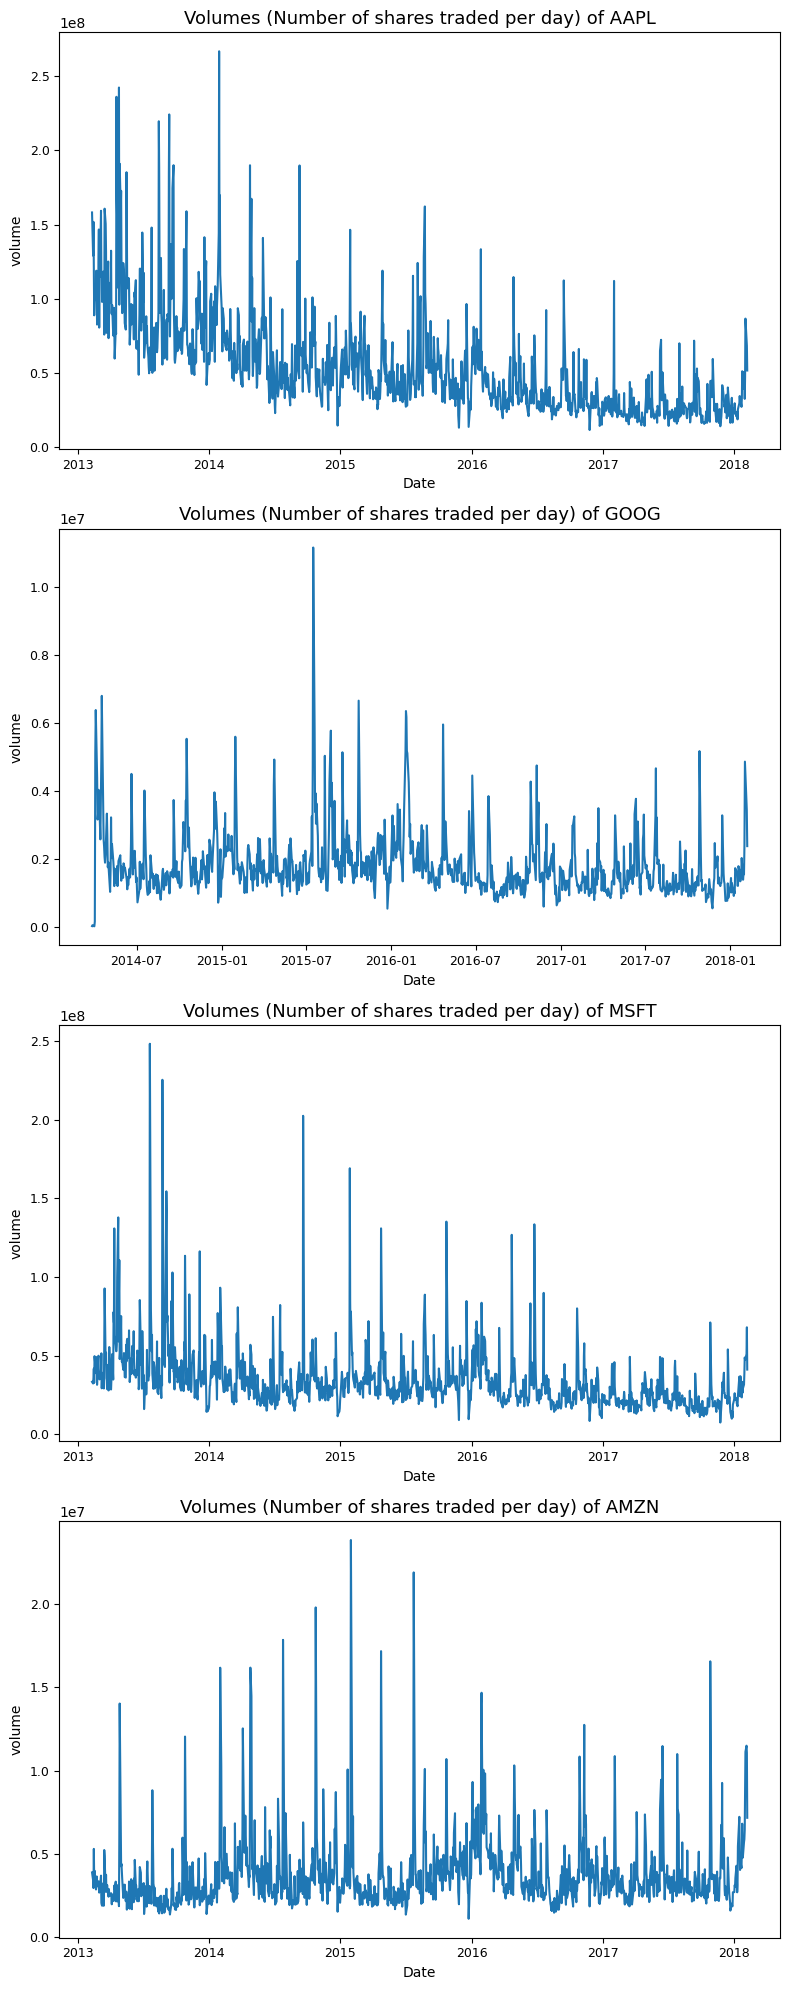

In [51]:
# To Create subplots for each company
fig, axes = plt.subplots(len(selected_companies), 1, figsize=(8, 5 * len(selected_companies)))

# Plot the closing prices vs dates for each company
for i, company in enumerate(selected_companies):
    data = filtered_df[filtered_df['company_name'] == company]
    ax = axes[i] if len(selected_companies) > 1 else axes
    ax.plot(data.index, data['volume'])
    ax.set_xlabel('Date', fontsize = 10)
    ax.set_ylabel('volume', fontsize = 10)
    ax.set_title(f'Volumes (Number of shares traded per day) of {company}', fontsize = 13)
    # Decrease the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize= 9)
    ax.tick_params(axis='y', labelsize= 9)


plt.tight_layout()
plt.show()

## Predicting the Closing Prices

To Predict the closing prices of stocks of different companies, we can use different models in such a way:


1.   Using All stocks data

> *   LSTM

> *   LSTM (with additional hidden and dense layers)


2.   Individual stock data

> *   LSTM

> *   LSTM (with additional hidden and dense layers)






### Spliting the dataset:





*   First the dataset will be splitted into features (X) and label (Y). Here our label is 'closing_price' while the remaining columns are considered as features.

*   The Features (X) and labels (Y) are then splited into train-test datasets.



In [10]:
# Split the data into features (X) and target (y)
X = df.drop('closing_price', axis=1)
X = X.drop('company_name', axis = 1)
X.head()

,open,high,low,volume
date,,,,
2013-02-08,15.07,15.1200,14.630,8407500
2013-02-08,81.22,81.9300,80.940,296853
2013-02-08,78.24,79.0700,78.125,4632684
2013-02-08,236.64,238.6924,235.750,552207
2013-02-08,89.04,89.4800,88.910,554948


In [11]:
Y = df['closing_price']
Y.head()

date
2013-02-08     14.75
2013-02-08     81.89
2013-02-08     79.07
2013-02-08    238.16
2013-02-08     89.16
Name: closing_price, dtype: float64

In [12]:
# Spliting the dataset into train-test datasets as:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

In [13]:
# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data to 3D format required by LSTM (samples, time steps, features)
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [14]:
print(X_test_reshaped.shape)
print(X_test_reshaped[0])
print(y_test[0])
print(y_test.shape)

(123808, 1, 4)
[[0.03179268 0.03178797 0.03177907 0.01097561]]
53.93
(123808,)


In [18]:
from keras import backend as K

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)

## Predicting Model 01: LSTM

In [16]:

# Initialize the model
model = Sequential()

# Add the first LSTM layer
model.add(LSTM(units=64, activation='relu', input_shape=(1, X_train_scaled.shape[1])))

# Add a fully connected layer
model.add(Dense(units=1))


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[mean_squared_error, mean_absolute_error])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [18]:

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

Epoch 1/10
15476/15476 [==============================] - 92s 6ms/step - loss: 1581.5447 - mean_squared_error: 1581.5447 - mean_absolute_error: 11.2973 - val_loss: 37.5028 - val_mean_squared_error: 37.5028 - val_mean_absolute_error: 1.3034
Epoch 2/10
15476/15476 [==============================] - 77s 5ms/step - loss: 1.3949 - mean_squared_error: 1.3949 - mean_absolute_error: 0.6120 - val_loss: 7.3216 - val_mean_squared_error: 7.3216 - val_mean_absolute_error: 0.6812
Epoch 3/10
15476/15476 [==============================] - 71s 5ms/step - loss: 1.1200 - mean_squared_error: 1.1200 - mean_absolute_error: 0.5455 - val_loss: 5.4641 - val_mean_squared_error: 5.4641 - val_mean_absolute_error: 0.6555
Epoch 4/10
15476/15476 [==============================] - 83s 5ms/step - loss: 1.0979 - mean_squared_error: 1.0979 - mean_absolute_error: 0.5370 - val_loss: 6.2114 - val_mean_squared_error: 6.2114 - val_mean_absolute_error: 0.6411
Epoch 5/10
15476/15476 [==============================] - 78s 5ms/s

In [19]:
# Save the trained model
model.save('trained_model_01.h5')

In [ ]:
from keras.models import load_model

# Load the saved model
model = load_model('trained_model_01.h5')

In [20]:
train_loss = model.evaluate(X_train_reshaped, y_train)
test_loss = model.evaluate(X_test_reshaped, y_test)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

3869/3869 [==============================] - 8s 2ms/step - loss: 3.5117 - mean_squared_error: 3.5117 - mean_absolute_error: 0.6234
Train Loss: [1.1437976360321045, 1.1437976360321045, 0.5049893260002136]
Test Loss: [3.5117435455322266, 3.5117435455322266, 0.6234230399131775]


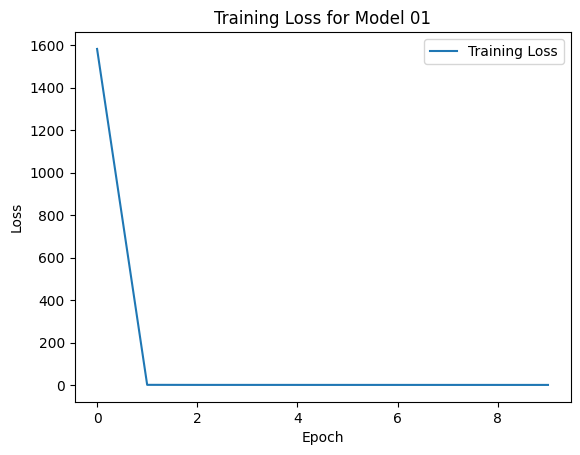

In [21]:
# Plot the training loss over the epochs
plt.plot(history.history['loss'])
plt.title('Training Loss for Model 01')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

### ==> Now After training the model on 'ALL_Stock' dataset, we will predict the closing prices of individual companies and will check the model performance

In [22]:
def load_data(company):

    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.company_name == company, :]
    return dataframe


# Defining Function to predict closing prices for individual companies using Model_01
def ind_com_mod1(Company_name):

    # Predicting on a single Company
    COMPANY = Company_name

    comp_data = load_data(company = COMPANY)
    # Split the data into features (X) and target (y)
    X = comp_data.drop('closing_price', axis=1)
    X = X.drop('company_name', axis = 1)
    # X.head()

    Y = comp_data['closing_price']

    # Split the data into features (X) and target (y)
    X = comp_data.drop('closing_price', axis=1)
    X = X.drop('company_name', axis = 1)
    # X.head()
    print(X.shape)

    Y = comp_data['closing_price']

    # Spliting the dataset into train-test datasets as:

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]

    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data to 3D format required by LSTM (samples, time steps, features)
    X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Use the model to make predictions on the test data
    test_predictions = model.predict(X_test_reshaped)
    str_final = 'Done'

    # predictions = model.predict(x_test)
    # predictions = scaler.inverse_transform(predictions)

    close_prices = comp_data['closing_price']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)

    if COMPANY == 'GOOG' :
        training_data_len = training_data_len
    else:
        training_data_len = training_data_len - 1


    data = comp_data.filter(['closing_price'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation.loc[:, 'Predictions'] = test_predictions

    # Plotting the closing_prices of an individual company
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train)
    ax.plot(validation[['closing_price', 'Predictions']])
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price ')
    ax.set_title(f'Closing prices for company: {COMPANY} (Based on Model_01)')
    ax.legend(['Training closing price', 'Actual closing price', 'Predicted closing price'], loc='upper left')
    plt.show()

    return str_final

(1259, 4)
8/8 [==============================] - 0s 4ms/step


<ipython-input-22-f6474da041e8>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


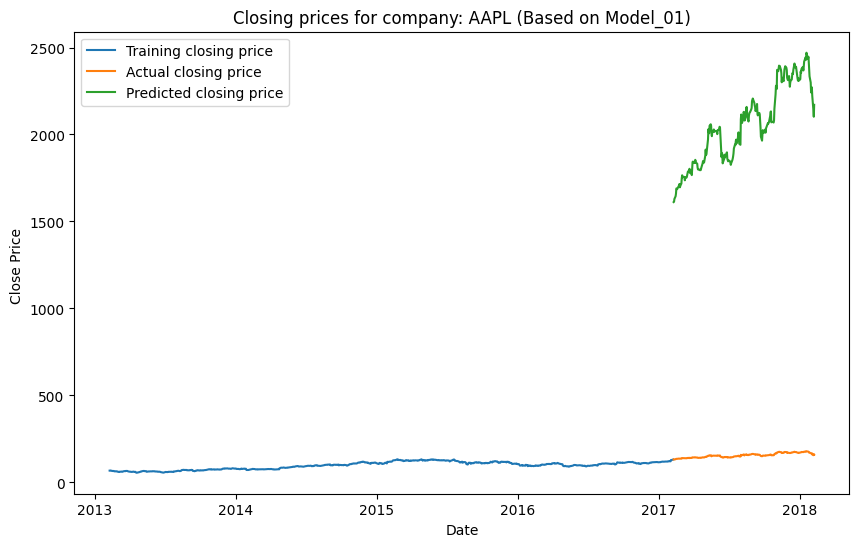

Done
(975, 4)
7/7 [==============================] - 0s 4ms/step


<ipython-input-22-f6474da041e8>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


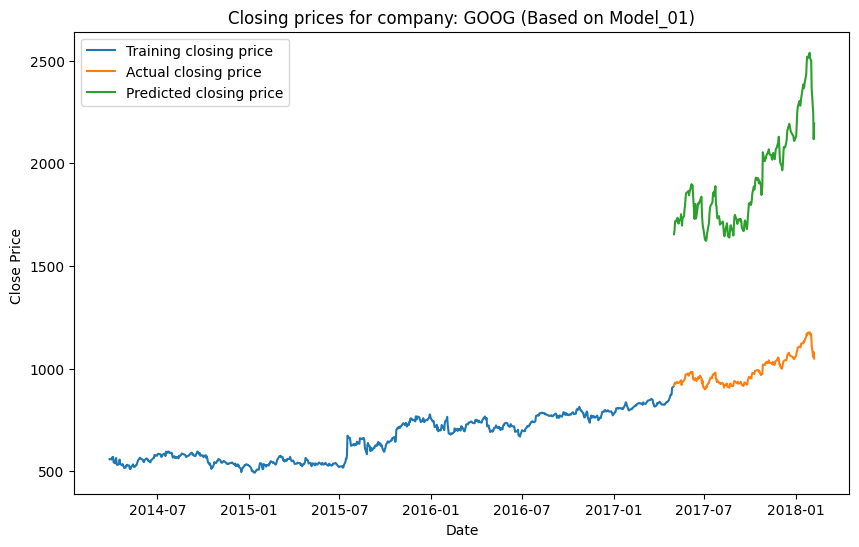

Done
(1259, 4)
8/8 [==============================] - 0s 3ms/step


<ipython-input-22-f6474da041e8>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


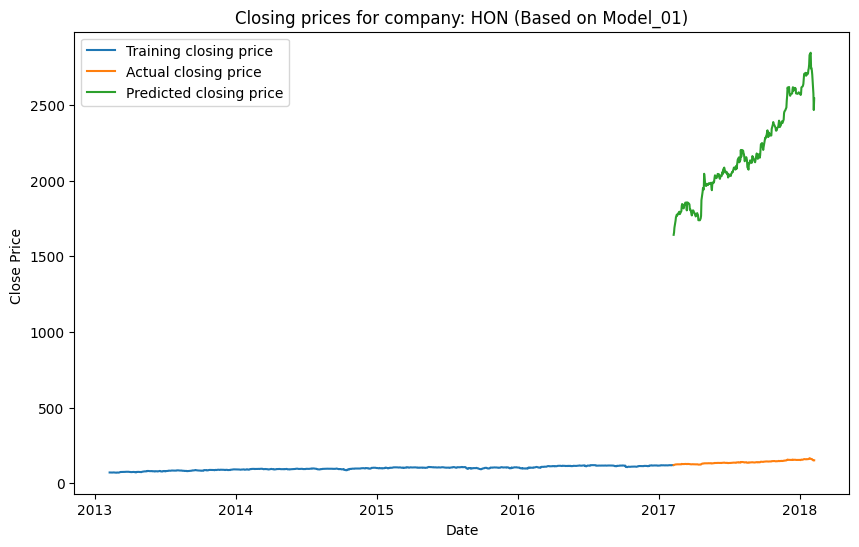

Done
(1259, 4)
8/8 [==============================] - 0s 3ms/step


<ipython-input-22-f6474da041e8>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


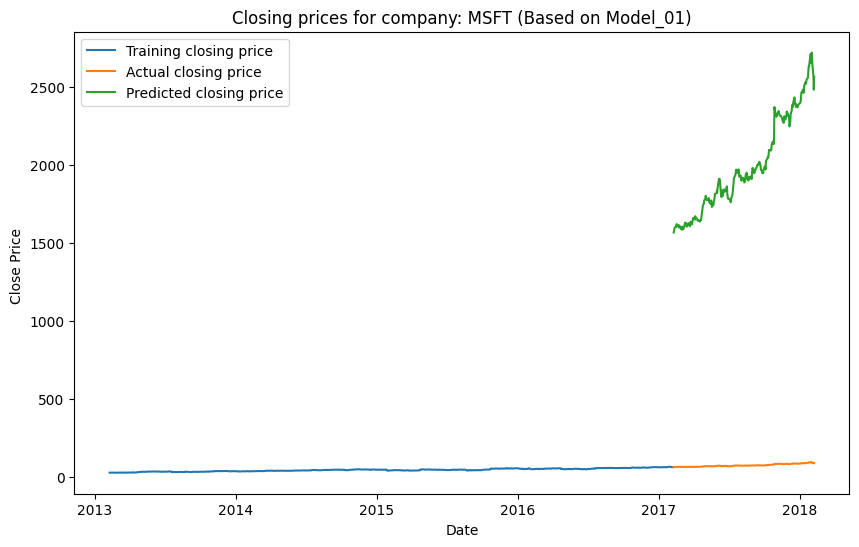

Done
(1259, 4)
8/8 [==============================] - 0s 3ms/step


<ipython-input-22-f6474da041e8>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


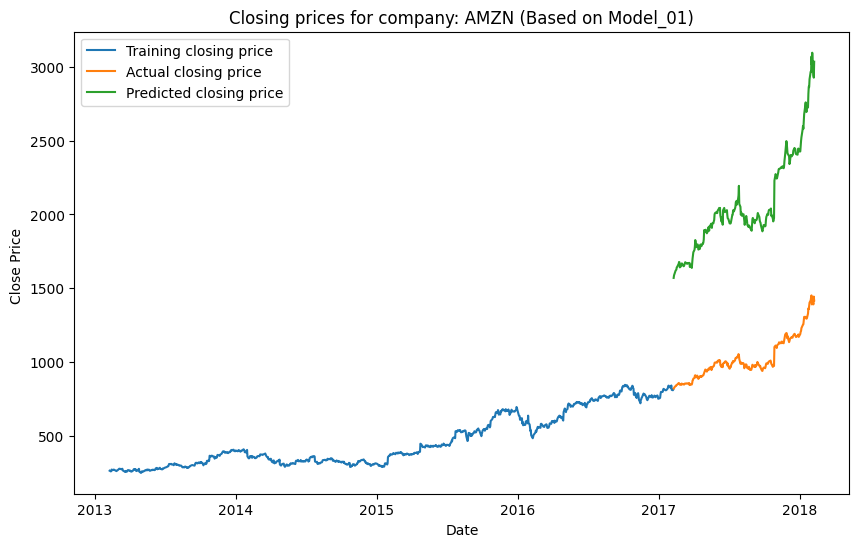

Done


In [23]:

# Predicting for a list of 5 famous companies:
comp_list = ['AAPL', 'GOOG', 'HON', 'MSFT', 'AMZN']

# Calling Function for individual companies closing price prediction
for comp_name in comp_list:
    Indi_mod1 = ind_com_mod1(comp_name)
    print(Indi_mod1)


## Predictive model 02: Advanced LSTM

In [15]:

# Initialize the model
model_2 = Sequential()

# Add the first LSTM layer with dropout
model_2.add(LSTM(units=64, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True))
model_2.add(Dropout(0.15))

# Add the second LSTM layer with dropout
model_2.add(LSTM(units=64, activation='tanh', return_sequences=True))
model_2.add(Dropout(0.5))

# Add the third LSTM layer with dropout
model_2.add(LSTM(units=64, activation='relu'))
#model_2.add(Dropout(0.2))

# # Add a fully connected layer
model_2.add(Dense(units=1))

# Model summary will be:
model_2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             17664     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 83,777
Trainable params: 83,777
Non-traina

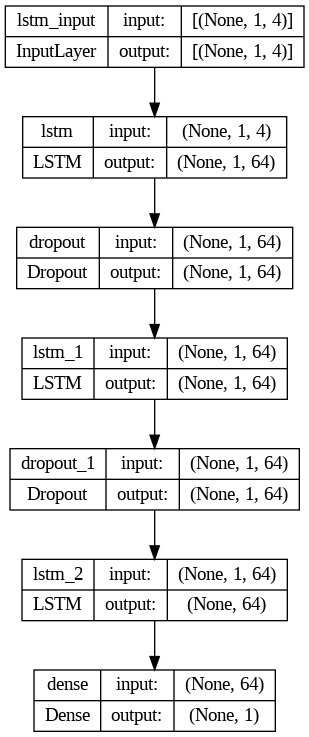

In [16]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model_2, to_file='model_architecture.png', show_shapes=True)

In [19]:
# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=[mean_absolute_error])


In [20]:
# training the model 02:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')


history = model_2.fit(X_train_reshaped, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

Epoch 1/20
15476/15476 [==============================] - 137s 8ms/step - loss: 499.6764 - mean_absolute_error: 7.9051 - val_loss: 194.6411 - val_mean_absolute_error: 2.2765
Epoch 2/20
15476/15476 [==============================] - 131s 8ms/step - loss: 137.6487 - mean_absolute_error: 5.1210 - val_loss: 267.6713 - val_mean_absolute_error: 3.6981
Epoch 3/20
15476/15476 [==============================] - 147s 9ms/step - loss: 117.8569 - mean_absolute_error: 4.9508 - val_loss: 90.8473 - val_mean_absolute_error: 1.6741
Epoch 4/20
15476/15476 [==============================] - 151s 10ms/step - loss: 108.2584 - mean_absolute_error: 4.8818 - val_loss: 77.7422 - val_mean_absolute_error: 2.4246
Epoch 5/20
15476/15476 [==============================] - 171s 11ms/step - loss: 103.0205 - mean_absolute_error: 4.8437 - val_loss: 165.8318 - val_mean_absolute_error: 2.3412
Epoch 6/20
15476/15476 [==============================] - 124s 8ms/step - loss: 97.1631 - mean_absolute_error: 4.8281 - val_loss: 

In [21]:
# Save the trained model
model_2.save('trained_model_02.h5')

In [ ]:
from keras.models import load_model

# Load the saved model
model_2 = load_model('trained_model_02.h5')

In [22]:
train_loss_2 = model_2.evaluate(X_train_reshaped, y_train)

print("Train Loss:", train_loss_2)

15476/15476 [==============================] - 47s 3ms/step - loss: 10.4429 - mean_absolute_error: 1.9985
Train Loss: [10.44289779663086, 1.9985415935516357]


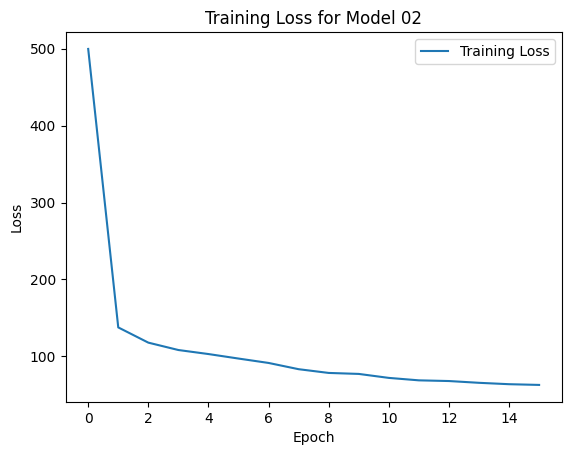

In [23]:
# Plot the training loss and validation loss over the epochs
plt.plot(history.history['loss'])
plt.title('Training Loss for Model 02')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [24]:
def load_data(company):

    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.company_name == company, :]
    return dataframe


# Defining Function to predict closing prices for individual companies using Model_01
def ind_com_mod2(Company_name):

    # Predicting on a single Company
    COMPANY = Company_name

    comp_data = load_data(company = COMPANY)
    # Split the data into features (X) and target (y)
    X = comp_data.drop('closing_price', axis=1)
    X = X.drop('company_name', axis = 1)
    # X.head()

    Y = comp_data['closing_price']

    # Split the data into features (X) and target (y)
    X = comp_data.drop('closing_price', axis=1)
    X = X.drop('company_name', axis = 1)
    # X.head()
    print(X.shape)

    Y = comp_data['closing_price']

    # Spliting the dataset into train-test datasets as:

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]

    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data to 3D format required by LSTM (samples, time steps, features)
    X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Use the model to make predictions on the test data
    test_predictions = model_2.predict(X_test_reshaped)
    str_final = 'DONE'

    close_prices = comp_data['closing_price']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)

    if COMPANY == 'GOOG' :
        training_data_len = training_data_len
    else:
        training_data_len = training_data_len - 1


    data = comp_data.filter(['closing_price'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation.loc[:, 'Predictions'] = test_predictions

    # Plotting the closing_prices of an individual company
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train)
    ax.plot(validation[['closing_price', 'Predictions']])
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price ')
    ax.set_title(f'Closing prices for company: {COMPANY} (Based on Model_02)')
    ax.legend(['Training closing price', 'Actual closing price', 'Predicted closing price'], loc='upper left')

    plt.show()

    return str_final

(1259, 4)
8/8 [==============================] - 1s 3ms/step


<ipython-input-24-0fc75aa1a1e6>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


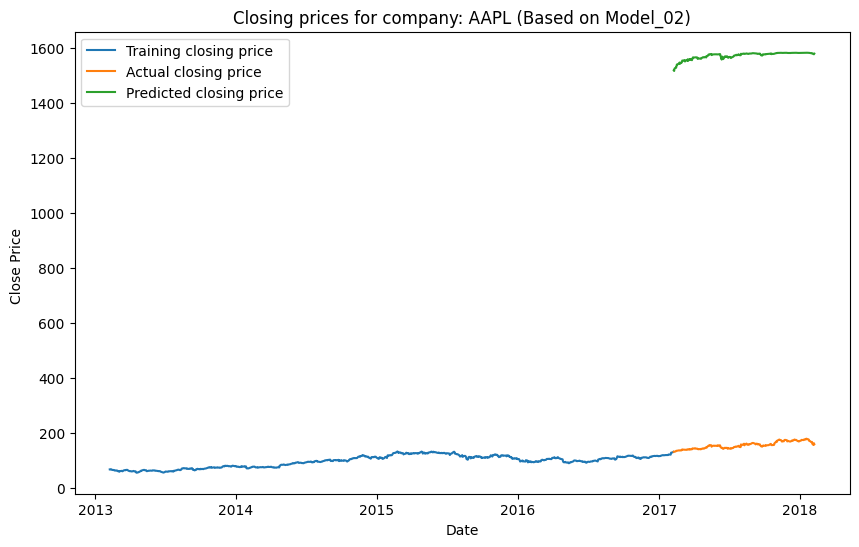

DONE
(975, 4)
7/7 [==============================] - 0s 3ms/step


<ipython-input-24-0fc75aa1a1e6>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


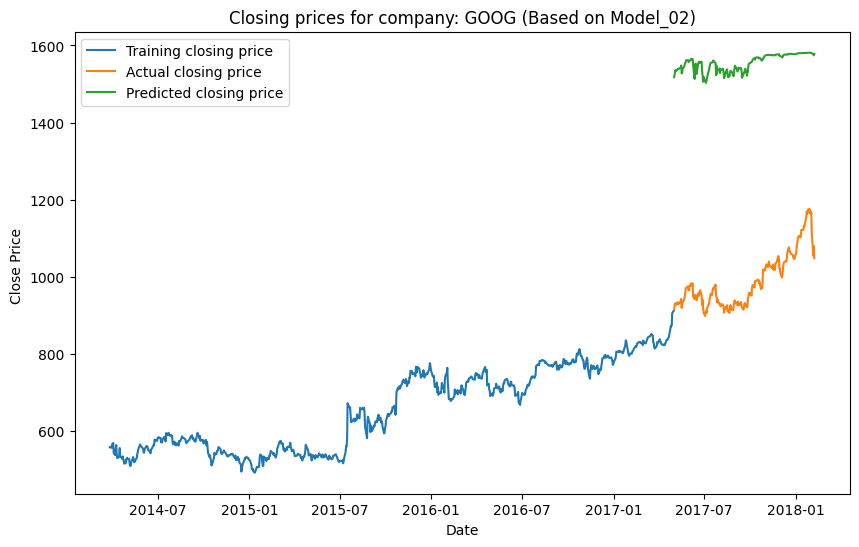

DONE
(1259, 4)
8/8 [==============================] - 0s 3ms/step


<ipython-input-24-0fc75aa1a1e6>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


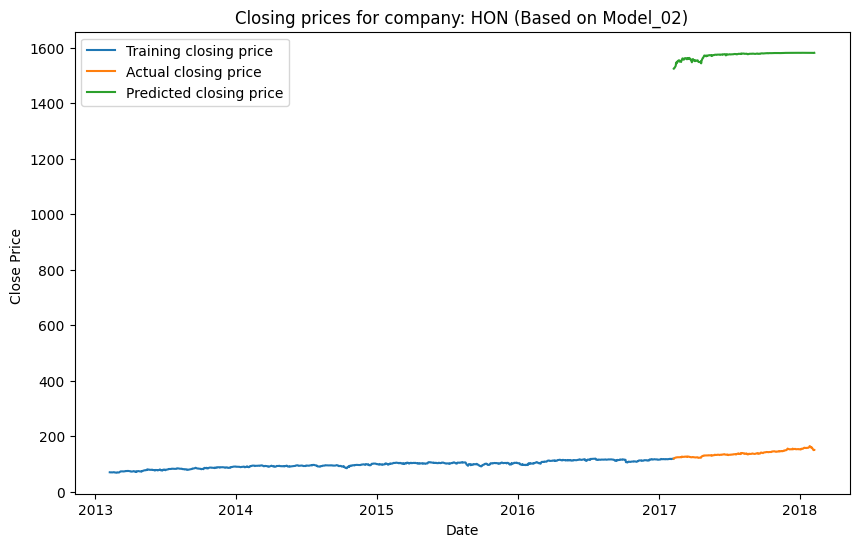

DONE
(1259, 4)
8/8 [==============================] - 0s 5ms/step


<ipython-input-24-0fc75aa1a1e6>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


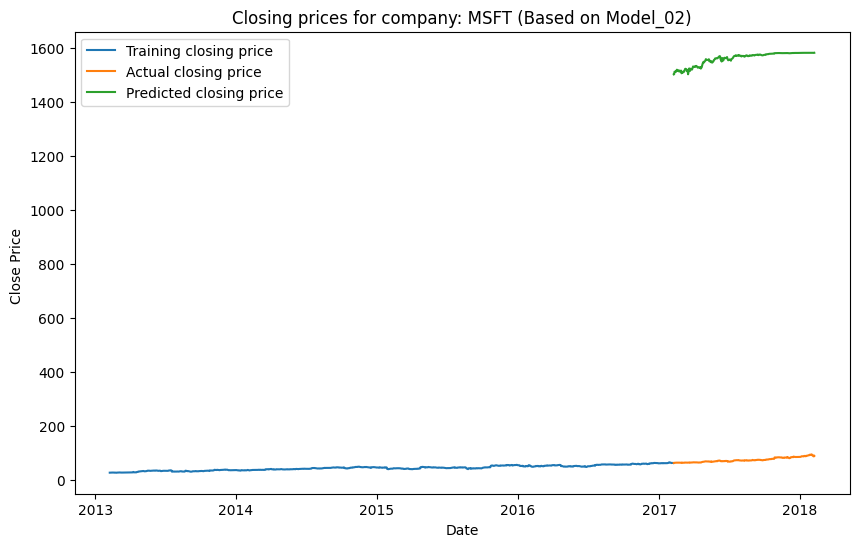

DONE
(1259, 4)
8/8 [==============================] - 0s 3ms/step


<ipython-input-24-0fc75aa1a1e6>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = test_predictions


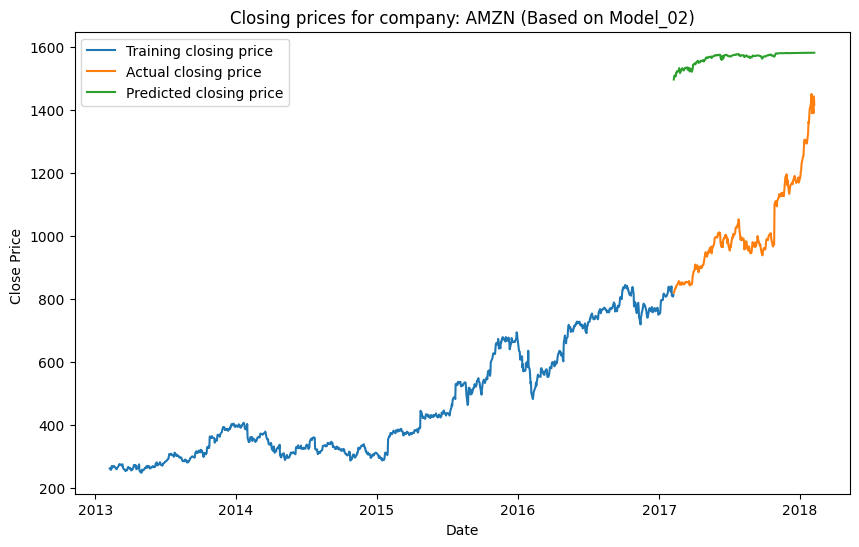

DONE


In [25]:

# Predicting for a list of 5 famous companies:
comp_list = ['AAPL', 'GOOG', 'HON', 'MSFT', 'AMZN']

# Calling Function for individual companies closing price prediction
for comp_name in comp_list:
    Indi_mod2 = ind_com_mod2(comp_name)
    print(Indi_mod2)


##  Pipeline for Predicted model of individual companies

Its a generalized pipeline to predict the closing price of any stock company. It requires only one parameter:


1.   Company name



In [26]:
# Defining required functions:


def load_data(company):

    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.company_name == company, :]
    return dataframe


def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)

#### ==> Just specify the name of the company and it will predict its closing price

In [27]:

# Defining Function to predict closing prices for individual companies
def func_ind_comp(Company_name):

    # Predicting on a single Company
    COMPANY = Company_name

    # calling the data loader function
    df_mfst = load_data(company = COMPANY)

    close_prices = df_mfst['closing_price']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)

    # Normalizing the features
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    train_data = scaled_data[0: training_data_len, :]

    # Train test splitting
    x_train = []
    y_train = []
    past_trans=60
    for i in range(past_trans, len(train_data)):
        x_train.append(train_data[i-past_trans:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    test_data = scaled_data[training_data_len-past_trans: , : ]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(past_trans, len(test_data)):
      x_test.append(test_data[i-past_trans:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Model definition to predict the closing prices
    model = tensorflow.keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))

    model.add(layers.Dense(25))
    model.add(layers.Dense(1))

    # Summary of the model
    model.summary()

    #Model Compilling
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Model training
    history = model.fit(x_train, y_train ,batch_size= 256, epochs=5)
    final_stat = 'Done'

    # Plotting the closing_prices of 4 famous companies
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(history.history['loss'], label = f'{COMPANY}')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training loss for company: {COMPANY}')
    plt.show()


    # predicting Closing prices:
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    data = df_mfst.filter(['closing_price'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predictions'] = predictions

    # Plotting the closing_prices of an individual company
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train)
    ax.plot(validation[['closing_price', 'Predictions']])
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price ')
    ax.set_title(f'Closing prices for company: {COMPANY}')
    ax.legend(['Training closing price', 'Actual closing price', 'Predicted closing price'], loc='upper right')

    plt.show()

    return final_stat


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4/4 [==============================] - 4s 24ms/step - loss: 0.0632
Epoch 2/5
4/4 [==============================] - 0s 21ms/step - loss: 0.0159
Epoch 3/5
4/4 [===========

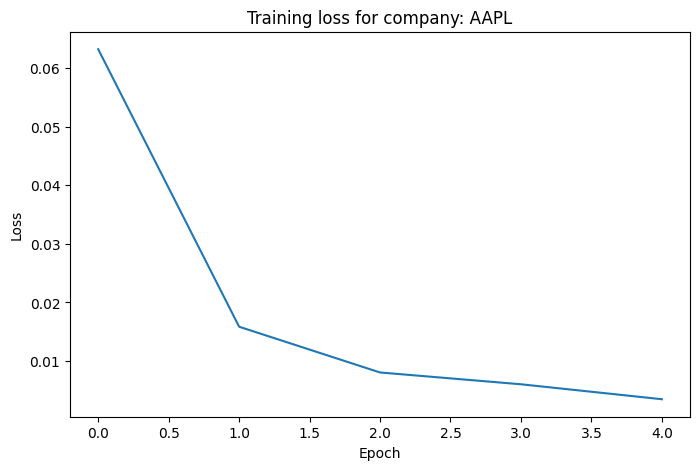

8/8 [==============================] - 1s 4ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


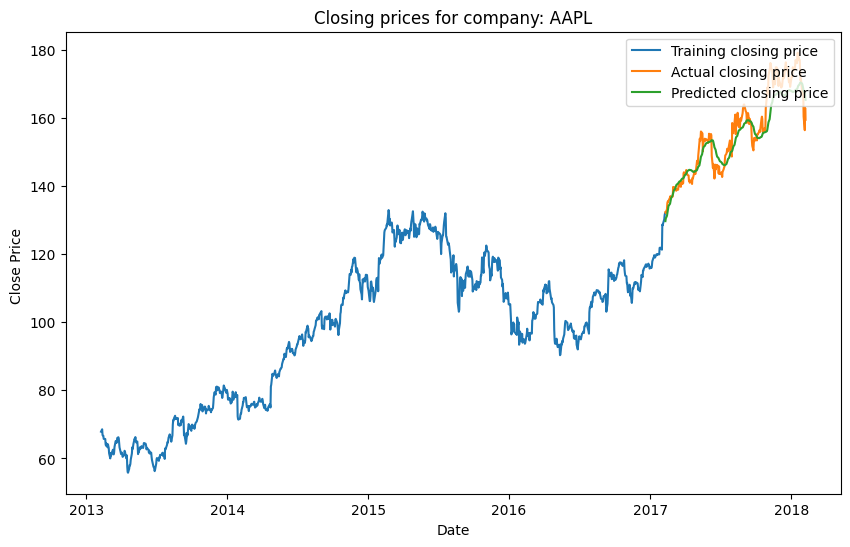

Done
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 25)                2525      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3/3 [==============================] - 5s 21ms/step - loss: 0.0507
Epoch 2/5
3/3 [==============================] - 0s 20ms/step - loss: 0.0144
Epoch 3/5
3/3 [======

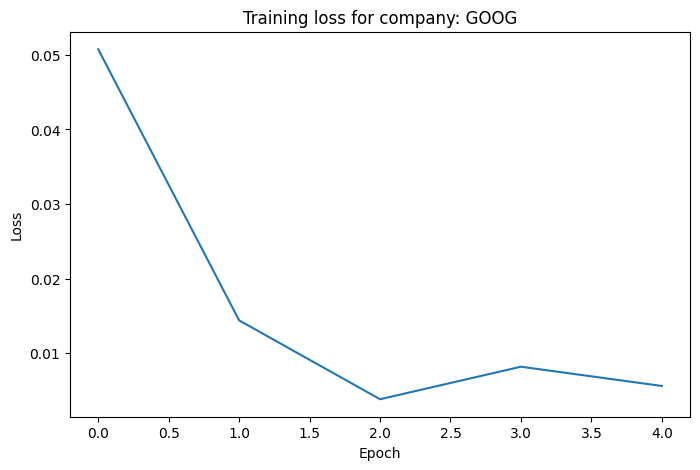

7/7 [==============================] - 1s 4ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


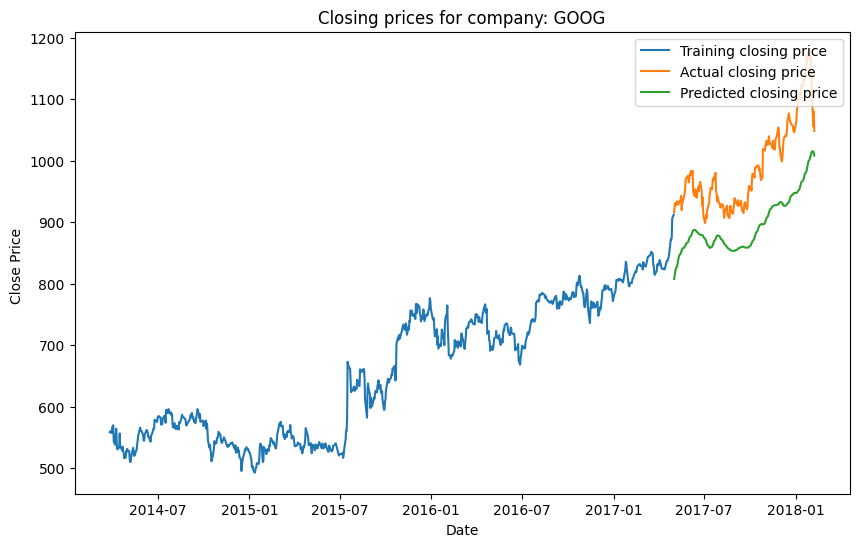

Done
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 25)                2525      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4/4 [==============================] - 4s 22ms/step - loss: 0.0403
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0092
Epoch 3/5
4/4 [======

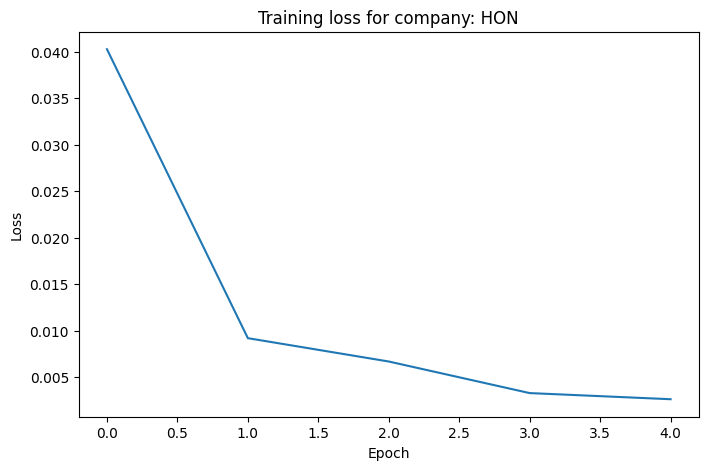

8/8 [==============================] - 1s 5ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


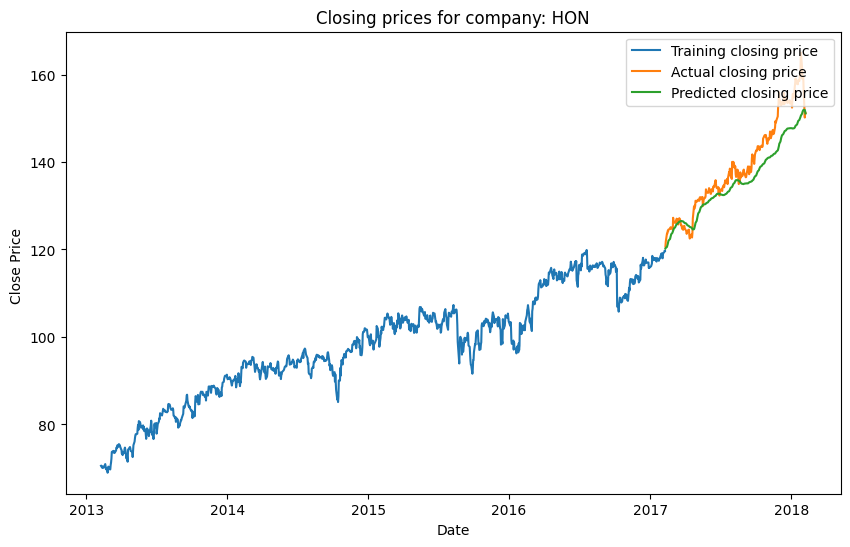

Done
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_10 (LSTM)              (None, 100)               80400     
                                                                 
 dense_7 (Dense)             (None, 25)                2525      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4/4 [==============================] - 5s 22ms/step - loss: 0.0419
Epoch 2/5
4/4 [==============================] - 0s 22ms/step - loss: 0.0115
Epoch 3/5
4/4 [======

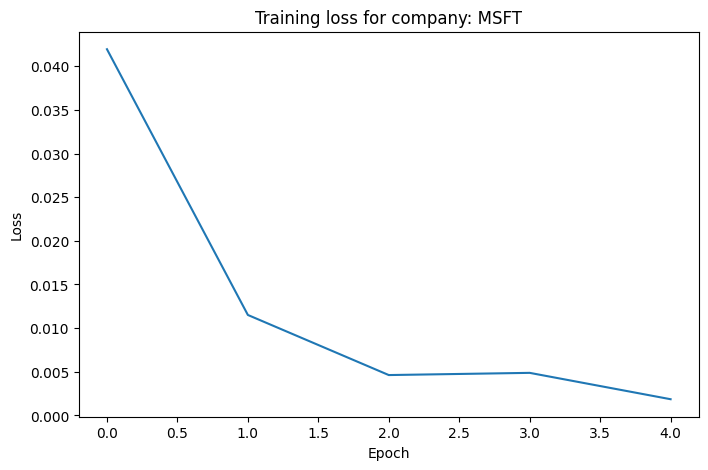

8/8 [==============================] - 1s 4ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


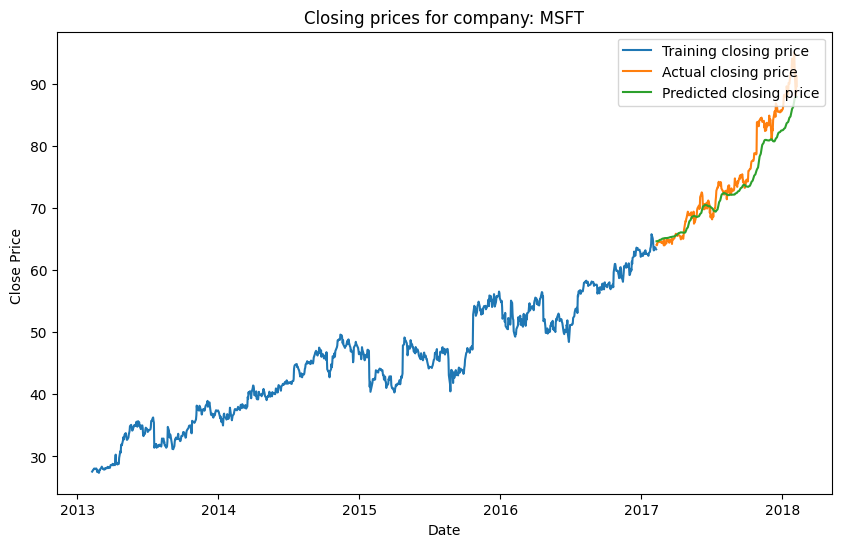

Done
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_12 (LSTM)              (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 25)                2525      
                                                                 
 dense_10 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4/4 [==============================] - 4s 23ms/step - loss: 0.0257
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0081
Epoch 3/5
4/4 [======

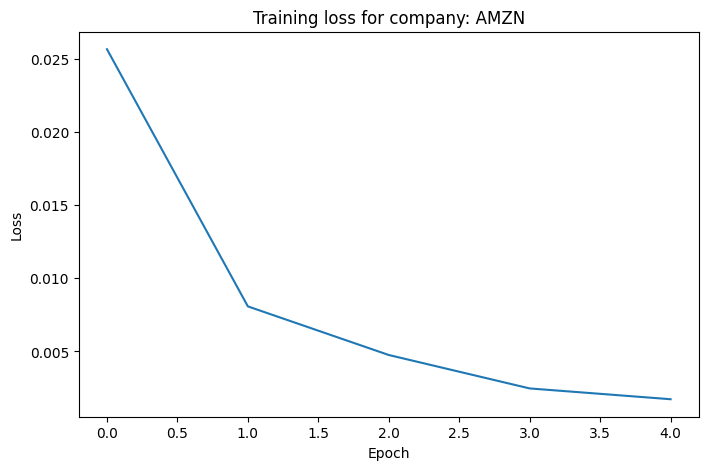

8/8 [==============================] - 1s 4ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


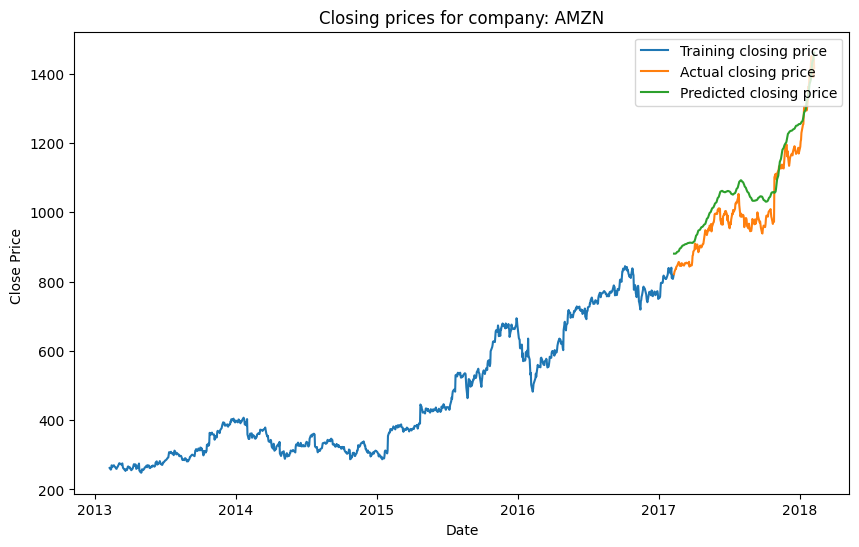

Done


In [28]:
# Predicting for a list of 5 famous companies:
comp_list = ['AAPL', 'GOOG', 'HON', 'MSFT', 'AMZN']

# Calling Function for individual companies closing price prediction
for comp_name in comp_list:
    Indi_mod2 = func_ind_comp(comp_name)
    print(Indi_mod2)
# .......................................... OR ........................

# TO train and visualize model performance for individual companies, We can call the function in each cell:

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dense_11 (Dense)            (None, 25)                2525      
                                                                 
 dense_12 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4/4 [==============================] - 5s 21ms/step - loss: 0.0454
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0103
Epoch 3/5
4/4 [===========

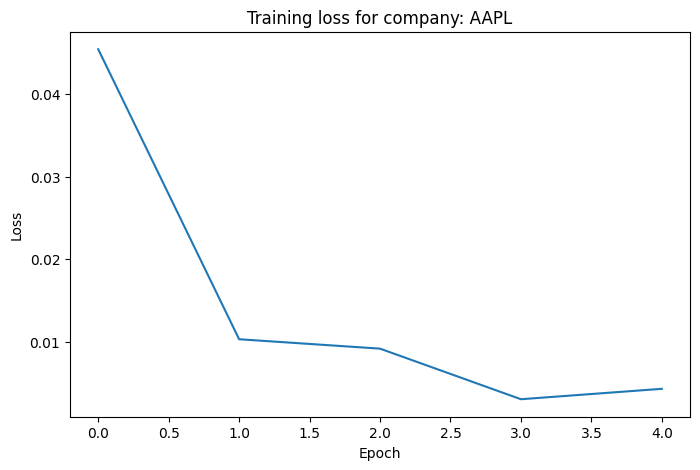

8/8 [==============================] - 1s 4ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


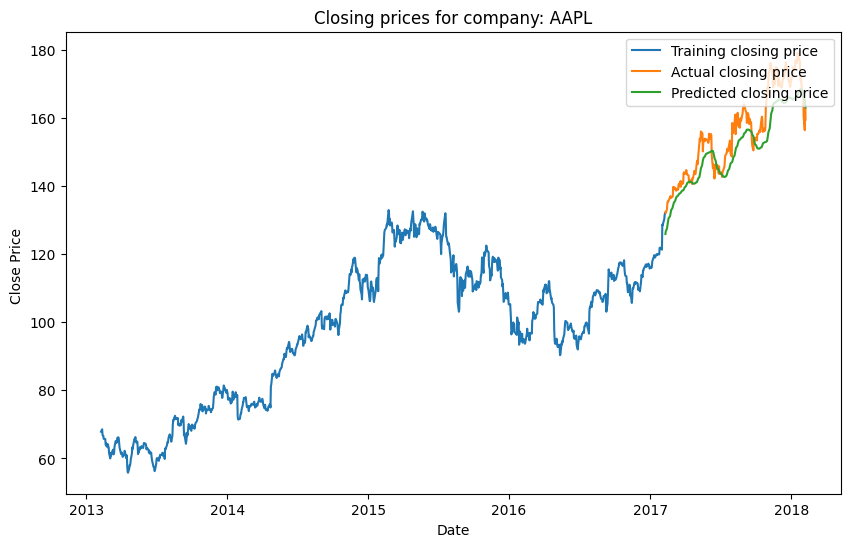

Done


In [29]:
# Calling for APPLE :
comp_name = 'AAPL'
Indi_mod2 = func_ind_comp(comp_name)
print(Indi_mod2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_16 (LSTM)              (None, 100)               80400     
                                                                 
 dense_13 (Dense)            (None, 25)                2525      
                                                                 
 dense_14 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4/4 [==============================] - 4s 22ms/step - loss: 0.0589
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0148
Epoch 3/5
4/4 [===========

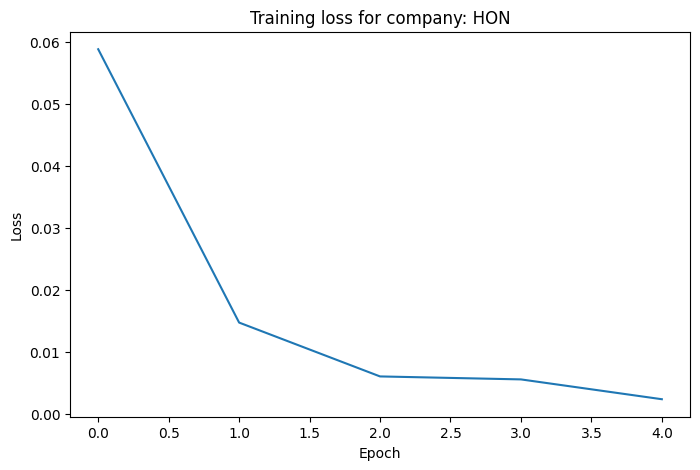

8/8 [==============================] - 1s 4ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


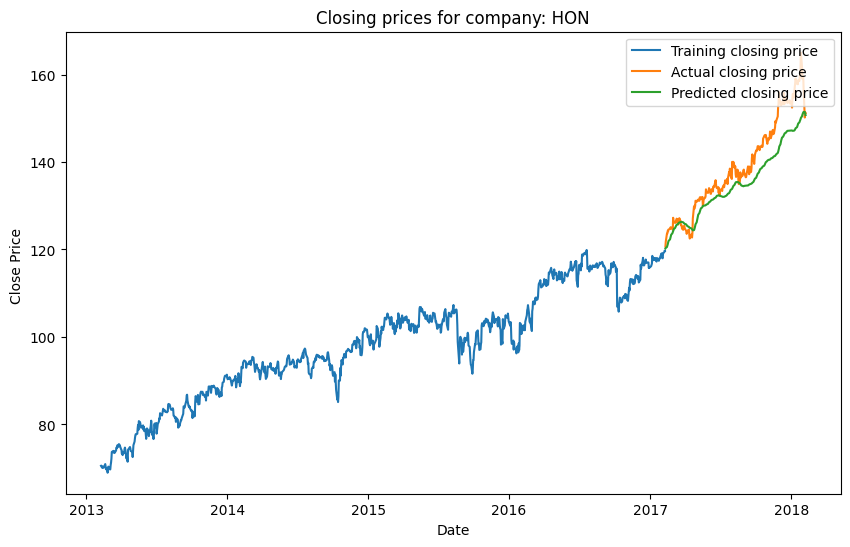

Done


In [30]:
# Calling for HONDA :
comp_name = 'HON'
Indi_mod2 = func_ind_comp(comp_name)
print(Indi_mod2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_18 (LSTM)              (None, 100)               80400     
                                                                 
 dense_15 (Dense)            (None, 25)                2525      
                                                                 
 dense_16 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4/4 [==============================] - 5s 22ms/step - loss: 0.0388
Epoch 2/5
4/4 [==============================] - 0s 21ms/step - loss: 0.0102
Epoch 3/5
4/4 [===========

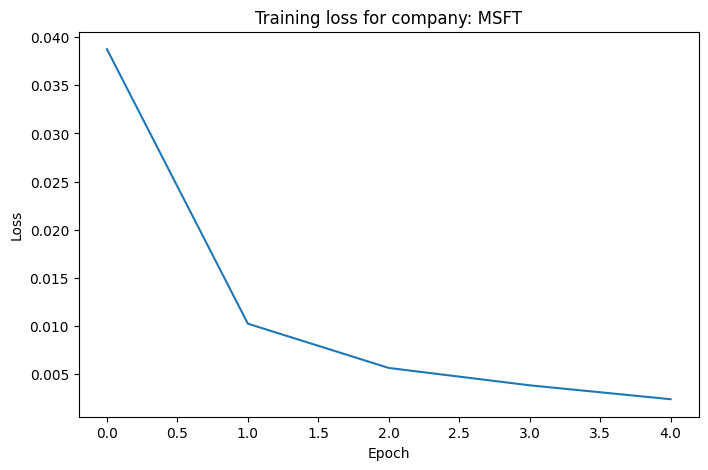

8/8 [==============================] - 1s 6ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


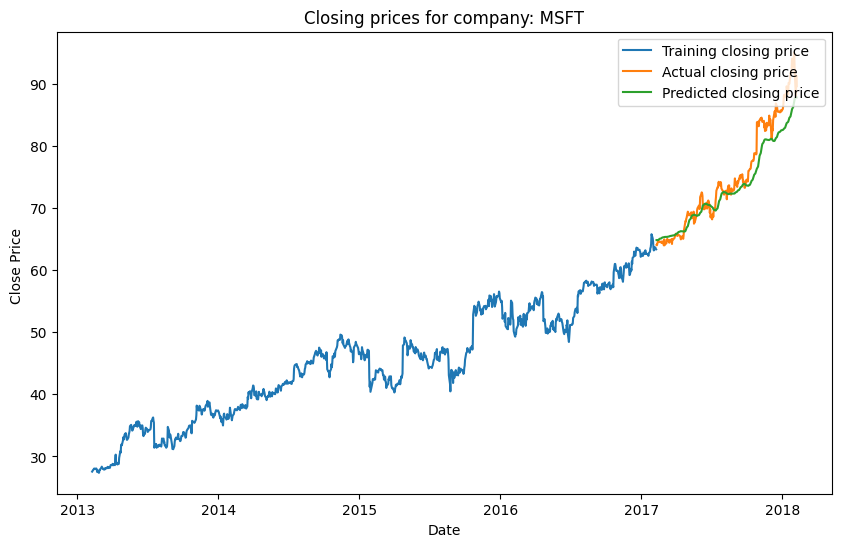

Done


In [31]:
# Calling for Microsoft :
comp_name = 'MSFT'
Indi_mod2 = func_ind_comp(comp_name)
print(Indi_mod2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_20 (LSTM)              (None, 100)               80400     
                                                                 
 dense_17 (Dense)            (None, 25)                2525      
                                                                 
 dense_18 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3/3 [==============================] - 4s 23ms/step - loss: 0.0350
Epoch 2/5
3/3 [==============================] - 0s 20ms/step - loss: 0.0122
Epoch 3/5
3/3 [===========

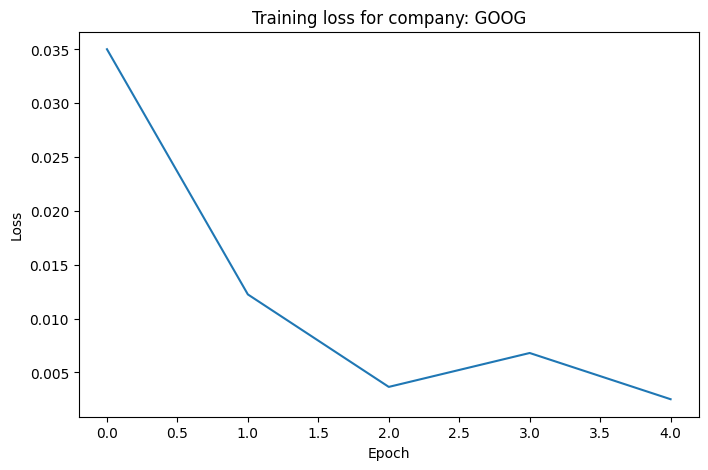

7/7 [==============================] - 1s 4ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


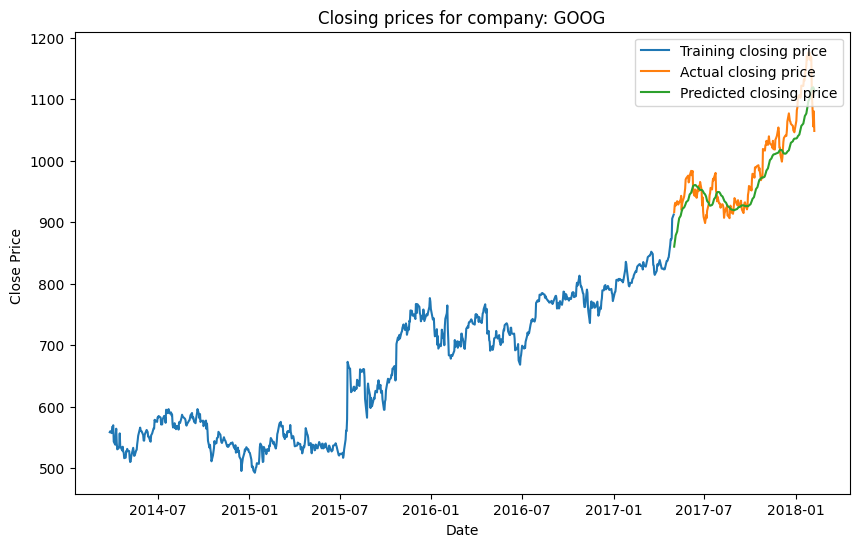

Done


In [32]:
# Calling for Google :
comp_name = 'GOOG'
Indi_mod2 = func_ind_comp(comp_name)
print(Indi_mod2)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_22 (LSTM)              (None, 100)               80400     
                                                                 
 dense_19 (Dense)            (None, 25)                2525      
                                                                 
 dense_20 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4/4 [==============================] - 5s 21ms/step - loss: 0.0318
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0084
Epoch 3/5
4/4 [==========

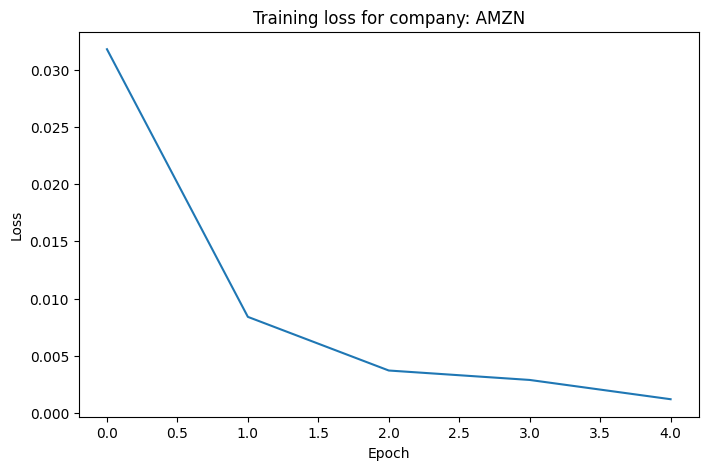

8/8 [==============================] - 1s 4ms/step


<ipython-input-27-afa98efd6f38>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


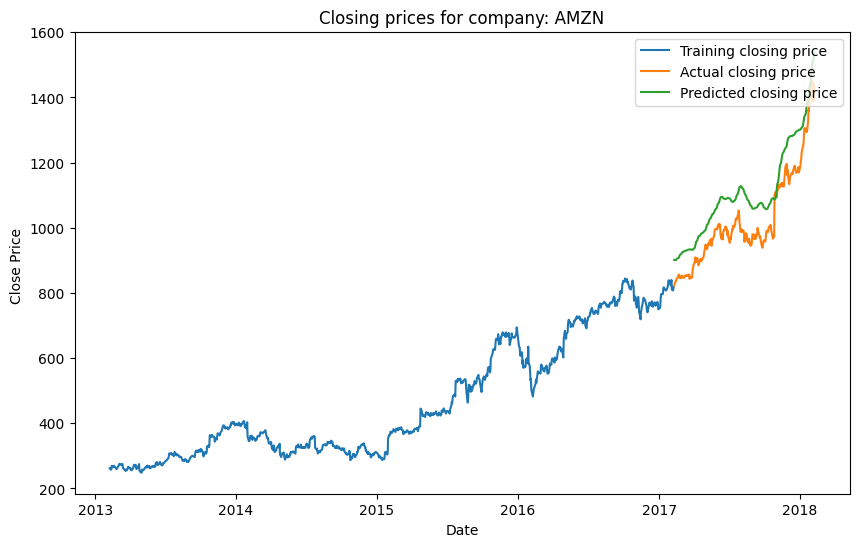

Done


In [33]:
# Calling for AMAZON :
comp_name = 'AMZN'
Indi_mod2 = func_ind_comp(comp_name)
print(Indi_mod2)